## Flooded ice in the Weddell Sea

We're interested in looking at flooded ice in the Weddell sea for a number of reasons, one specific reason is that snow ice is derived from flooded ice processes. This snow ice is an indirect freshwater input in the global system. Here, we're just looking at the ice thickness from one track in the Weddell Sea.


In [ ]:
pip install astropy

In [ ]:
pip install reader

In [ ]:
pip install metpy

In [27]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IS2view
import pprint
import metpy
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)
import scipy
from astropy.time import Time
#import utils as ut
#import reader as rd
import icepyx as ipx
import earthaccess
import h5py

import geopandas as gpd
from shapely.geometry import Point
import os
import seaborn as sns
import xarray as xr
import hvplot.xarray
%matplotlib inline

In [8]:
auth = earthaccess.login()
# attempt to use cloud streaming if in us-west-2
try:
    provider = "NSIDC_CPRD"
    asset = "nsidc-s3"
    fs = earthaccess.get_s3fs_session(provider=provider)
except (AttributeError, NameError) as exc:
    provider = "NSIDC_ECS"

    asset = "nsidc-https"

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/jovyan


Enter your Earthdata Login username:  julliancbw9
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/07/2023
Using user provided credentials for EDL


In [5]:
# spatial extent -54.15,-74.88,-35.14,-69.71

In [37]:
result = ipx.Query(
    product="ATL10",
    spatial_extent = [-54.15,-74.88,-35.14,-69.71],
    date_range = ['2020-03-01','2020-03-30'],
)

In [38]:
gran_id = result.avail_granules()
gran_id

{'Number of available granules': 52,
 'Average size of granules (MB)': 37.21873215528077,
 'Total size of all granules (MB)': 1935.3740720745996}

In [39]:
result = ipx.Query(
    product="ATL10",
    spatial_extent = [-54.15,-74.88,-35.14,-69.71],
    date_range = ['2020-03-01','2020-03-30'],
)
s3links = result.avail_granules(cloud=True)[0]  # returns a nested list, get first element
s3links

['s3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/01/ATL10-02_20200301043422_10000601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/01/ATL10-02_20200301170841_10080601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/02/ATL10-02_20200302040842_10150601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/02/ATL10-02_20200302181718_10240601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/03/ATL10-02_20200303051719_10310601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/03/ATL10-02_20200303175138_10390601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/04/ATL10-02_20200304045140_10460601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/04/ATL10-02_20200304172558_10540601_006_01.h5',
 's3://nsidc-cumulus-prod-protected/ATLAS/ATL10/006/2020/03/05/ATL10-02_20200305042601_10610601_006_01.h5',
 's3://nsidc-cumulus-prod-pr

In [40]:
result = earthaccess.search_data(
    short_name = 'ATL10',
    version = '005',
    cloud_hosted = True,
    bounding_box = (-54.15,-74.88,-35.14,-69.71),
    temporal = ('2020-03-01','2020-03-30'),
    count = 100
)

Granules found: 51


In [42]:
files = earthaccess.open(result)
ds = xr.open_dataset(files[49],group='/gt3r/freeboard_beam_segment')

AttributeError: 'NoneType' object has no attribute 'open'

In [ ]:
[display(r) for r in result] #map plots

In [111]:
ds

<xarray.Dataset>
Dimensions:                        (delta_time: 134, ds_si_hist_bins: 161)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 2020-03-29T04:...
  * ds_si_hist_bins                (ds_si_hist_bins) int32 1 2 3 ... 159 160 161
    latitude                       (delta_time) float64 -67.66 -67.75 ... -65.26
    longitude                      (delta_time) float64 ...
Data variables: (12/16)
    beam_fb_height                 (delta_time) float32 nan nan ... nan nan
    beam_fb_hist                   (delta_time, ds_si_hist_bins) int16 ...
    beam_fb_length                 (delta_time) float32 ...
    beam_fb_sigma                  (delta_time) float32 ...
    beam_lead_n                    (delta_time) int32 ...
    beam_lead_ndx                  (delta_time) int32 ...
    ...                             ...
    beam_refsurf_geoid_free2mean   (delta_time) float32 ...
    beam_refsurf_height            (delta_time) float32 ...
    beam_refsurf_interp_flag       (delta_time) int16 ...
    beam_refsurf_mss               (delta_time) float32 ...
    beam_refsurf_sigma             (delta_time) float32 ...
    fbswath_ndx                    (delta_time) int32 ...
Attributes:
    Description:  Contains freeboard estimate and associated height segment p...
    data_rate:    Data within this group are stored at the freeboard swath se...

Using average values for sea ice thickness conversions from:
* Tilling, R.L., Ridout, A. and Shepherd, A. (2018) ‘Estimating Arctic sea ice thickness and volume using cryosat-2 Radar Altimeter Data’, Advances in Space Research, 62(6), pp. 1203–1225. doi:10.1016/j.asr.2017.10.051.
* Zhao, J. et al. (2019) ‘Observation and thermodynamic modeling of the influence of snow cover on landfast sea ice thickness in Prydz Bay, East Antarctica’, Cold Regions Science and Technology, 168, p. 102869. doi:10.1016/j.coldregions.2019.102869. 

In [36]:
lat = ds['latitude']
lon = ds['longitude']
fb = ds['beam_fb_height']
denw = 1023.9
dens = 324
densi = 916.7
depsnow = 0.5

NameError: name 'ds' is not defined

Ice thickness assumption based equation

hi = ((fb*1023.9)+(depsnow*dens))/((denw-densi))

In [73]:
#Looping through all values to calculate ice thickness
for x in fb:
    hi = ((fb*1023.9)+(depsnow*dens))/((denw-densi))
print (hi)

<xarray.DataArray 'beam_fb_height' (delta_time: 134)>
array([      nan,       nan, 3.8723173, 3.6157324, 3.1030154, 3.3516283,
       3.2523215,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan, 1.7288975, 1.8959781, 2.1210823,
       2.1104016,       nan, 1.9919237, 2.1267016, 3.1781929, 2.885448 ,
       2.664938 , 3.2048972, 2.8398452, 3.9663863, 3.4659884, 2.6357305,
       3.6761487, 4.0299926, 3.6700246, 2.8774993, 2.5954428, 2.5393302,
       2.7660499, 2.6932137, 2.6932213, 2.8353922, 2.851151 , 3.1260512,
       2.9959972, 2.6453133, 2.66468  , 2.9061327, 5.6533318, 5.1617455,
       2.8210552, 3.5794194, 3.2635813, 2.8882883, 3.8046358,       nan,
             nan, 3.0630426, 2.9450004, 3.0135512, 2.7723863, 3.8653555,
       3.1428635, 3.2290425, 3.8469837, 4.096751 , 3.5842583, 2.881900

In [35]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size':10})
width = 0.2
edgecolor='black'
alpha=0.2
plt.scatter(lat,fb,s=2, c='o')
plt.xlabel("latitude", fontsize=10)
plt.ylabel("freeboard(m)", fontsize=10)

NameError: name 'lat' is not defined

Text(0, 0.5, 'ice thickness(m)')

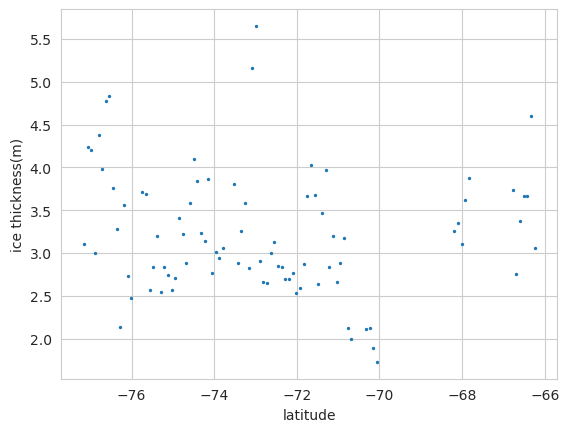

In [75]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size':10})
width = 0.2
edgecolor='black'
alpha=0.2
plt.scatter(lat,hi,s=2)
plt.xlabel("latitude", fontsize=10)
plt.ylabel("ice thickness(m)", fontsize=10)

We might want to look at the change in ice thickness over time for each trackline.
However, because of the mobility of ice in the Antartic Ocean, the ice floes detected along this track, is unlikely to recurr along track some time later. Even more so, the ice featurecan change through erosion, congelation etc. It would therefore be best to track specific floes over time. 